In this notebook we will process the synthetic Austen/food reviews data and convert it into feature vectors. In later notebooks these feature vectors will be the inputs to models which we will train and eventually use to identify spam. 

Feature vectors are composed of simple summaries of the documents. 

In [1]:
import pandas as pd

df = pd.read_parquet("data/training.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [2]:
#note level and index coincide for the legitimate documents, but not for the spam - 
    #for spam, index = level_0 mod 20,000
df.reset_index(inplace=True) 

In [3]:
df.sample(10)

,level_0,index,label,text
5566,5566,5566,legitimate,But how she contrives it without reflecting on...
5128,5128,5128,legitimate,You shall share its use with me. When I saw th...
15171,15171,15171,legitimate,As long as Mr. Knightley used even to the dest...
39374,39374,19374,spam,"As a vegetarian, I'm always searching for a go..."
32371,32371,12371,spam,They are the best. It was a big disappointment...
32823,32823,12823,spam,I was very curious as to your results. And the...
39740,39740,19740,spam,"Thsi are hard to find, not sold in any stores ..."
9429,9429,9429,legitimate,"We were married, you know, it is sometimes car..."
1575,1575,1575,legitimate,"You will not want to see or understand. It is,..."
31836,31836,11836,spam,If I could have been just awful. He does not b...


We can now "explode" the text into words, so that each word occupies a row of the data frame, and retains the associated "level_0", "index" and "label". 

In [4]:
rows = []
_ = df.apply(lambda row: [rows.append([row['level_0'], row['index'], row['label'], word]) 
                         for word in row.text.split()], axis=1)
df_explode = pd.DataFrame(rows, columns=df.columns)

In [5]:
df_explode[1:10]

,level_0,index,label,text
1,0,0,legitimate,must
2,0,0,legitimate,write
3,0,0,legitimate,to
4,0,0,legitimate,me.
5,0,0,legitimate,Catherine
6,0,0,legitimate,sighed.
7,0,0,legitimate,And
8,0,0,legitimate,there
9,0,0,legitimate,are


Column "level_0" contains the index we want to aggregate any calculations over. 

The summmaries we are going to compute for each document (indexed by "level_0") are: 
    number of words in each document
    average word length
    maximum word length
    minimum word length
    10th percentile word length
    90th percentile word length
    number of upper case words
    
    
Many of these require the word length to be computed. To save us from recomputing this every time, we will begin add a column containing this information to our 'exploded' data frame. 


In [6]:
df_explode["word_len"] = df_explode["text"].apply(len) 

In [7]:
df_explode.sample(10)

,level_0,index,label,text,word_len
1548009,17203,17203,legitimate,The,3
2867702,33419,13419,spam,I,1
474156,5320,5320,legitimate,evening,7
1960711,22031,2031,spam,think,5
1213413,13465,13465,legitimate,he,2
1349778,15011,15011,legitimate,the,3
2474654,28455,8455,spam,that,4
348719,3893,3893,legitimate,report,6
1162881,12908,12908,legitimate,most,4
321610,3582,3582,legitimate,very,4


We will record the summaries for each document in a new data frame called summaries. We start by computing the number of words in each document. 

In [8]:
counts = df_explode['level_0'].value_counts()

df_summaries = pd.DataFrame({'counts' :counts})

In [9]:
df_summaries.sample(10)

,counts
18662,35
22205,81
21415,97
18814,109
23723,58
27416,89
19945,174
35283,72
20184,80
32405,65


In [10]:
df_summaries["av_wl"] = df_explode.groupby('level_0')['word_len'].mean() #average word length

In [11]:
df_summaries["max_wl"] = df_explode.groupby('level_0')['word_len'].max() #max word length
df_summaries["min_wl"] = df_explode.groupby('level_0')['word_len'].min() #min word length

In [12]:
df_summaries["10_quantile"] = df_explode.groupby('level_0')['word_len'].quantile(0.1) #10th quantile word length
df_summaries["90 quantile"]= df_explode.groupby('level_0')['word_len'].quantile(0.9) #90th quantile word length

In [13]:
#number of words containing atleast one capital letter.
#item.islower returns true if all characters are lowercase, else false.
#note: isupper only returns true if all characters are upper case. 
def caps(word):
    return not word.islower()
df_explode["upper_case"]=df_explode['text'].apply(caps)
df_summaries["upper_case"] = df_explode.groupby('level_0')['upper_case'].sum() 

In [14]:
df_summaries.sample(10)

,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case
22197,72,4.347222,11,1,2.0,7.0,9.0
9110,110,4.427273,10,1,2.0,8.0,11.0
37734,84,4.797619,29,1,2.0,7.0,10.0
19812,154,4.435065,12,1,2.0,8.0,18.0
3710,83,4.554217,12,1,2.0,8.0,7.0
24998,71,4.647887,11,1,2.0,8.0,10.0
31749,67,4.343284,14,1,2.0,7.0,9.0
14708,16,4.562500,11,1,2.0,9.0,2.0
14538,79,4.481013,11,1,2.0,8.0,17.0
4725,103,4.737864,13,1,2.0,8.0,21.0


As well as the simple summaries relating to word length, we can compute some more involved summaries related to language. 

In [15]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [16]:
def isstopword(word):
    return word in ENGLISH_STOP_WORDS

df_explode["stop_words"]=df_explode['text'].apply(isstopword)

In [17]:
df_summaries["stop_words"] = df_explode.groupby('level_0')['stop_words'].sum() 

In [18]:
#Finally, we use regular expressions to count the number of pieces of punctuation in a document
import string
import regex as re

def punct_count(doc):
    return sum(bool(re.match(r"""[!.><:;'@#~{}\[\]-_+=£$%^&()?]""", c)) for c in doc)

In [19]:
df_summaries["punctuation"]=df['text'].apply(punct_count)

In [20]:
df_summaries.sample(10)

,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case,stop_words,punctuation,punct
25876,61,4.459016,11,1,2.0,8.0,18.0,22.0,10,10
25122,127,4.440945,13,1,2.0,8.0,21.0,58.0,13,13
18748,47,5.574468,16,1,2.6,10.0,4.0,23.0,8,8
38777,134,4.253731,10,1,2.0,7.0,26.0,55.0,21,21
18875,51,4.725490,13,1,1.0,9.0,6.0,24.0,3,3
33919,71,4.704225,11,1,2.0,7.0,11.0,28.0,12,12
4869,137,4.605839,14,1,2.0,9.0,14.0,71.0,10,10
34157,55,4.836364,20,1,2.0,7.6,15.0,22.0,25,25
32393,119,4.310924,12,1,2.0,7.0,14.0,58.0,12,12
29332,100,4.030000,14,1,2.0,7.0,15.0,44.0,12,12


In [21]:
import sklearn.decomposition

DIMENSIONS = 2

pca = sklearn.decomposition.PCA(DIMENSIONS)

pca_summaries = pca.fit_transform(df_summaries)

In [22]:
pca_summaries

array([[252.15526196,  -7.83886366],
       [250.10113016,  -6.87989753],
       [220.06744688, -11.01269483],
       ...,
       [-93.2137788 ,  -3.23264207],
       [-94.17609803,  -3.64386253],
       [-94.07760052,  -3.39714297]])

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


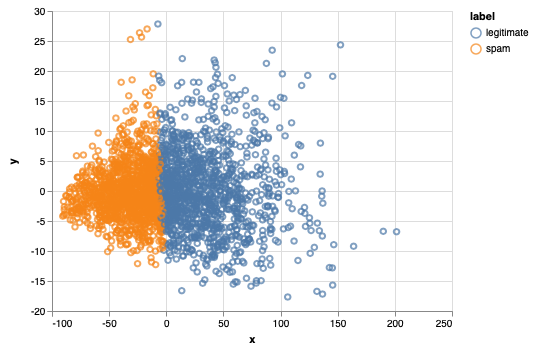

In [23]:
pca_summaries_plot_data = pd.concat([df, pd.DataFrame(pca_summaries, columns=["x", "y"])], axis=1)

#tsne_plot_data = pd.concat([sdf.reset_index(), pd.DataFrame(tsne_a, columns=["x", "y"])], axis=1)

from mlworkflows import plot

plot.plot_points(pca_summaries_plot_data, x="x", y="y", color="label")

In [24]:
labled_vecs = pd.concat([df[["index", "label"]],df_summaries], axis=1)

In [25]:
labled_vecs

,index,label,counts,av_wl,max_wl,min_wl,10_quantile,90 quantile,upper_case,stop_words,punctuation,punct
0,0,legitimate,124,4.879032,16,1,2.0,9.0,22.0,58.0,17,17
1,1,legitimate,88,5.022727,17,1,2.0,9.0,11.0,41.0,8,8
2,2,legitimate,139,4.496403,13,1,2.0,8.0,24.0,72.0,14,14
3,3,legitimate,94,4.680851,15,1,2.0,9.0,13.0,48.0,9,9
4,4,legitimate,80,4.525000,9,2,2.0,8.0,11.0,42.0,8,8
5,5,legitimate,103,4.669903,12,1,2.0,8.0,13.0,52.0,9,9
6,6,legitimate,48,4.500000,12,1,2.0,7.3,5.0,24.0,4,4
7,7,legitimate,101,4.386139,13,1,2.0,7.0,15.0,47.0,11,11
8,8,legitimate,89,4.404494,12,1,2.0,8.0,11.0,43.0,7,7
9,9,legitimate,108,4.814815,17,1,2.0,9.0,18.0,51.0,14,14


In [26]:
labled_vecs.columns = labled_vecs.columns.astype(str)

In [27]:
labled_vecs.to_parquet("data/simplesummaries_features.parquet")

/anaconda2/envs/ml-workflows-for-developers/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)
